In [15]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Read in the TDMS Files and Convert to Arrays

In [16]:
def read_tdms(tdms_file, datalen):
    ncol = int(tdms_file.properties['strips'])
    nrow = int(tdms_file.properties['bottom pixel'] - tdms_file.properties['top pixel'] + 1)
    data_cube = np.zeros((int(ncol*nrow), datalen))
    idx = 0
    for group in tdms_file.groups():
        group_name = group.name
        for channel in group.channels():
            channel_name = channel.name
            properties = channel.properties
            data = channel[:]
            data_cube[idx,:] = data
            idx = idx + 1
        break
    data_cube = np.reshape(data_cube, ((ncol, nrow, datalen)))
        
    for group in tdms_file.groups():
        group_name = group.name
        if group_name == 'Spectra':
            continue
        for channel in group.channels():
            channel_name = channel.name
            properties = channel.properties
            waves = channel[:]
            break    
        
    return waves, data_cube

In [17]:
path_int = '241015/aunr_14.tdms' # Dark-field scattering data 
pathwc = '241015/aunr_WC17.tdms' # White counts 
pathdc = '241015/aunr_DC18.tdms' # Dark counts

wvnth_grp_DFS = 2 # wavelength grouping used for dark-field scattering measurements 
wvnth_grp_WCDC = 1 # wavelength grouping used for white / dark count measurements 

wave_raw, inten_raw = read_tdms(tdms_file=TdmsFile.read(path_int), datalen=int(1340/wvnth_grp_DFS))
w1_raw, dc_raw =     read_tdms(tdms_file=TdmsFile.read(pathdc), datalen=int(1340/wvnth_grp_WCDC))
w2_raw, wc_raw =    read_tdms(tdms_file=TdmsFile.read(pathwc),  datalen=int(1340/wvnth_grp_WCDC))

# The wavelength arrays (wave_raw, w1, w2) need to be over an identical range. 
# If this is not the case, here is a dumb way to correct if DFS=2 and WCDC=1, by just grabbing every other point.
if wvnth_grp_DFS - wvnth_grp_WCDC == 1:
    dc = dc_raw[:,:,1:][:,:,::2]
    wc = wc_raw[:,:,1:][:,:,::2]
    w1 = w1_raw[1:][::2]
    w2 = w2_raw[1:][::2]


In [18]:
# Now, the spectrometer most trustworthy over the wavelength range 500 - 900 nm. 
# Trim the arrays to restrict yourself to this regime. 
s = 77
e = -68

waves = wave_raw[s:e]
I = inten_raw[:,:,s:e] # dim 0-1: x and y, dim 2: wavelength

# Spatially average white counts and dark counts 
dc_avg = np.mean(dc.reshape(8000, int(1340/wvnth_grp_DFS))[:,s:e], axis=0)
wc_avg = np.mean(wc.reshape(8000, int(1340/wvnth_grp_DFS))[:,s:e], axis=0)


DFS_NPs = I / (wc_avg - dc_avg)


## Crop your hyperspectral image around the NPs you wish to process

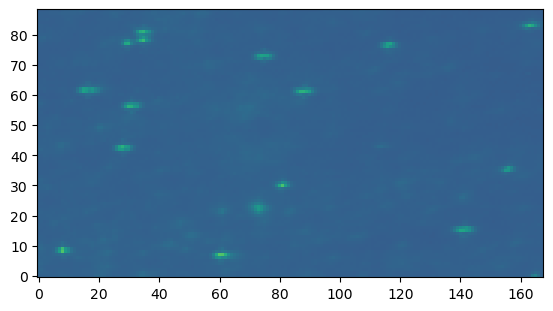

In [53]:
fig, ax = plt.subplots(1,1, figsize=[6,3], layout='compressed')

                        # bottom:top, right:left
DFS_NPs_cropped = DFS_NPs#[12:-13, 28:-220]
DFS_NPs_cropped = DFS_NPs[40:,100:]

DFS_summed_waves = np.sum(DFS_NPs_cropped, axis=-1)
    
ax.imshow(DFS_summed_waves, origin='lower', vmin=100, vmax=140)


ind_max = np.unravel_index(np.argmax(DFS_summed_waves, axis=None), DFS_summed_waves.shape)
ind_min = np.unravel_index(np.argmin(DFS_summed_waves, axis=None), DFS_summed_waves.shape)

## Fit the image to 2D Gaussians to identify each NP ## 

In [54]:
scaled = 1E2
def fit_2Dgauss(M, a, x0, c1, y0, c2, d):
    x, y = M
    return 1E1*a*np.exp(-((x-x0)**2 / (2*(c1)**2) + (y-y0)**2 / (2*(c2)**2))) + d*scaled


In [73]:
def find_the_NP(initial_data):
    ## Will sum all the wavelengths to located the NPs
    yrange = np.linspace(0, initial_data.shape[0], initial_data.shape[0])[::-1]
    xrange = np.linspace(0, initial_data.shape[1], initial_data.shape[1])
    datainit = initial_data
    X, Y = np.meshgrid(xrange, yrange)
    xdata = np.vstack((X.ravel(), Y.ravel()))
    Z = datainit.ravel()
    idxmax = np.argmax(Z)

    p0_x0 = xdata[0, idxmax]
    p0_y0 = xdata[1, idxmax]
    
    if p0_x0 == 0: p0_x0 = 0.1
    if p0_y0 == 0: p0_y0 = 0.1

    ##############################
    ind_max = np.unravel_index(np.argmax(datainit, axis=None), datainit.shape)       
        
    p0 = [5, p0_x0, 1, p0_y0, 1, 1]
    
    bounds = [[1,  p0_x0*0.95, 0.5, p0_y0*0.95,  0.5,  0],
              [10, p0_x0*1.05, 3,   p0_y0*1.05,    3, 100]]

    popt, pcov = curve_fit(fit_2Dgauss, xdata, Z, p0)#, bounds=bounds)
#     print(popt)
    fitdata = fit_2Dgauss(xdata, *popt).reshape(len(yrange), len(xrange))
    xyminmax = [np.min(X), np.max(X), np.min(Y), np.max(Y)]
    sbtrct_data = datainit-fitdata
    return xyminmax, datainit, fitdata, sbtrct_data, popt, xdata, ind_max


### Plot the raw data and fits to ensure done correctly

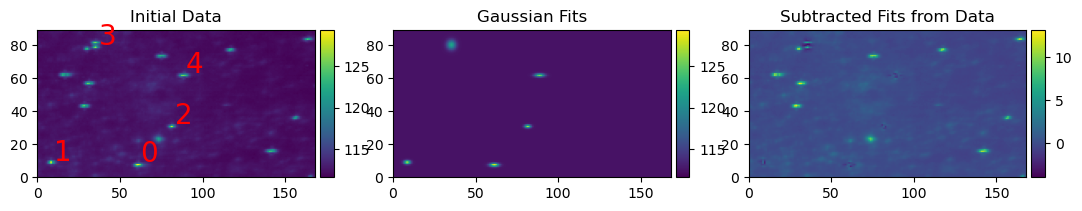

In [80]:
numparts = 5 # how many "NPs" do you wish to find fits for

all_data_init = []
all_fit_data = []
all_sbtrct_data = []
all_popt = []
all_indmax = []


xyminmax_i0, datainit_i0, fitdata_i0, sbtrct_data_i0, popt_i0, xdata_i0, ind_max0 = find_the_NP(initial_data=DFS_summed_waves)

all_data_init.append(datainit_i0)
all_fit_data.append(fitdata_i0)
all_sbtrct_data.append(sbtrct_data_i0)
all_popt.append(popt_i0)
all_indmax.append(ind_max0)

vmini = np.min(datainit_i0)
vmaxi = np.max(datainit_i0)

initial_data = sbtrct_data_i0

for i in range(numparts-1):
    xyminmax_i, datainit_i, fitdata_i, sbtrct_data_i, popt_i, _, ind_max = find_the_NP(initial_data=initial_data)
    all_data_init.append(datainit_i)
    all_fit_data.append(fitdata_i)

    all_sbtrct_data.append(sbtrct_data_i)
    all_popt.append(popt_i)
    all_indmax.append(ind_max)
    
    initial_data = sbtrct_data_i
    
fig, ax = plt.subplots(1,3, figsize=[13,5])

## Initial Data ##
im_init = ax[0].imshow(all_data_init[0],
             vmin=vmini, vmax=vmaxi,
             origin='lower',
             extent=(xyminmax_i0))
ax[0].set_title('Initial Data')
divider = make_axes_locatable(ax[0])
cax_ij = divider.append_axes("right", size="5%", pad=0.05)
cbarij = plt.colorbar(im_init, cax=cax_ij)



## Gaussian Fits ##
im_gaus = ax[1].imshow(np.sum(all_fit_data,axis=0),
            vmin=vmini, vmax=vmaxi,
             origin='lower',
             extent=(xyminmax_i0))
ax[1].set_title('Gaussian Fits')
divider = make_axes_locatable(ax[1])
cax_ij = divider.append_axes("right", size="5%", pad=0.05)
cbarij = plt.colorbar(im_gaus, cax=cax_ij)


## Subtracted Fits from Data ##
im_sub = ax[2].imshow(all_sbtrct_data[-1],
#             vmin=vmini, vmax=vmaxi,
             origin='lower',
             extent=(xyminmax_i0))
ax[2].set_title('Subtracted Fits from Data');
divider = make_axes_locatable(ax[2])
cax_ij = divider.append_axes("right", size="5%", pad=0.05)
cbarij = plt.colorbar(im_sub, cax=cax_ij)

# Draw a circle and place a number next to each identified NP
for i in range(numparts):
#     ax[0].add_patch(plt.Circle([all_indmax[i][1], all_indmax[i][0]], radius=3, edgecolor='r',lw=2, fill=False))        
    ax[0].annotate(str(i), fontsize=20, xy=[all_indmax[i][1]+2, all_indmax[i][0]+2],color='red')

    


## Processing for a single NP

In [75]:
## Let's look at a single NP


def process_single_NP(NPi, avpxl=1, plot_curves=False):
    # Center NP pixel
    x = all_indmax[NPi][0]
    y = all_indmax[NPi][1]
    
    # Avg. DFS over a given window
    DFS_wind = DFS_NPs_cropped[x-avpxl:x+avpxl+1, y-avpxl:y+avpxl+1, :]
    DFS_NPs_avg = np.mean(DFS_wind.reshape((2*avpxl+1)**2, DFS_wind.shape[-1]), axis=0)
    
    if plot_curves == True:
        for i in range(-1,2):
            for j in range(-1,2):
                plt.plot(waves, DFS_NPs_cropped[x+i, y+j, :], linewidth=3, alpha=.4, label=str(i)+str(j))
        plt.plot(waves, DFS_avg, color='k')
        plt.legend()
        
    # Find region to average over for I_back.
    # This will be the avpxl by avpxl region with the minimum signal.

    DFS_largewind = DFS_NPs_cropped[x-5:x+6, y-5:y+6, :]

    avg_ij_pxl = np.zeros((9,9))
    DFS_avgd_wind = np.zeros((DFS_largewind.shape[0]-1, DFS_largewind.shape[1]-1, 525))
    
    for cent_i in range(1,10):
        for cent_j in range(1,10):
            wind_ij = DFS_largewind[cent_i-1:cent_i+2, cent_j-1:cent_j+2, :]
            avg_ij_pxl[cent_i-1, cent_j-1] = np.sum(np.mean(wind_ij.reshape(9, wind_ij.shape[-1]), axis=0))
#             print(cent_i, cent_j, avg_ij_pxl[cent_i, cent_j])
    
    # This is the index in our window with the minimum signal.
    idx_min = np.unravel_index(np.argmin(avg_ij_pxl, axis=None), avg_ij_pxl.shape)       
    I_back_preavg = DFS_largewind[idx_min[0]:idx_min[0]+3, idx_min[1]:idx_min[1]+3]
    I_back_avg = np.mean(I_back_preavg.reshape((9, I_back_preavg.shape[-1])), axis=0)

    
    #     plt.imshow(np.mean(I_back_preavg,axis=-1))
#     plt.imshow(np.mean(DFS_largewind, axis=-1))
    
#     # To determine I_back, I fit a Gaussian to each wavelength and store the noise term,
#     # which will be I_back.

#     I_back = np.zeros(DFS_NPs_cropped.shape[-1])
    
#     for wave_i in range(DFS_NPs_cropped.shape[-1]):
#         data_smallwind = DFS_NPs_cropped[x-5:x+5, y-5:y+5, wave_i]
#         try:
#             _, _, fitdata_i, _, popt_i, _, _ = find_the_NP(initial_data=data_smallwind)
#         except RuntimeError:
#             pass
#         I_back[wave_i] = popt_i[-1]*scaled
    
    DFS_avg = DFS_NPs_avg - I_back_avg 
    return DFS_avg





[ 34. 759.]
[ 33. 731.]
[ 32. 727.]
[ 34. 726.]
[ 38. 773.]


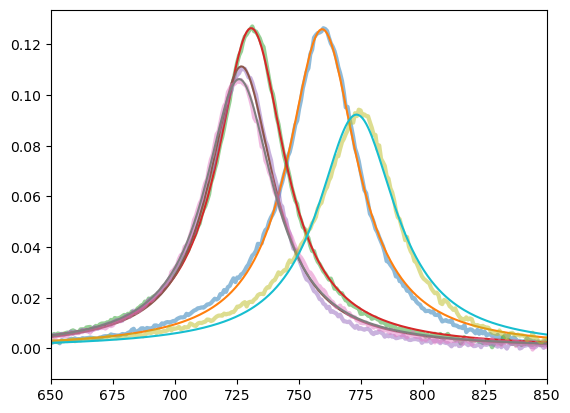

In [81]:
def fit_lorentz(wave, A, Gam, wave0):
    return A * 0.5 * Gam / ((wave-wave0)**2 + (0.5*Gam)**2)

for i in range(5):
    DFSi = process_single_NP(NPi=i, avpxl=1)


    plt.plot(waves, DFSi, alpha=.5, linewidth=3)

    p0 = [1, 30, 700]
    popt, pcov = curve_fit(fit_lorentz, waves, DFSi, p0)

    print(np.round(popt[1:]))

    plt.plot(waves, fit_lorentz(waves, *popt))

    plt.xlim([650,850])


In [ ]:
fig, ax = plt.subplots(4, numparts, figsize=[10,5])

for i in range(numparts):
    ## Plot the fit ##
    idx1, idx2 = np.unravel_index(np.argmax(np.abs(all_fit_data[i])), all_fit_data[i].shape)
    yrange = np.linspace(0, initial_data.shape[0], initial_data.shape[0])[::-1]
    xrange = np.linspace(0, initial_data.shape[1], initial_data.shape[1])

    ax[1,i].plot(xrange, all_fit_data[i][idx1,:], 'darkblue', linestyle='--')
    ax[2,i].plot(yrange, all_fit_data[i][:,idx2], 'darkgreen', linestyle='--')
    ax[1,i].set_xlim([all_popt[i][1]-15,all_popt[i][1]+15])
    ax[2,i].set_xlim([all_popt[i][3]-15,all_popt[i][3]+15])
    
    
    #############
    
    idx1, idx2 = np.unravel_index(np.argmax(np.abs(all_data_init[i])), all_data_init[i].shape)
    yrange = np.linspace(0, initial_data.shape[0], initial_data.shape[0])[::-1]
    xrange = np.linspace(0, initial_data.shape[1], initial_data.shape[1])


    ax[1,i].plot(xrange, all_data_init[i][idx1,:], 'darkblue', alpha=.5, linewidth=3)
    ax[2,i].plot(yrange, all_data_init[i][:,idx2], 'darkgreen', alpha=.5, linewidth=3)
    
    
    wind = 5
    if idx1 < wind:
        idx1_mini_l = 0
    else:
        idx1_mini_l = idx1 - wind
    idx1_mini_u = idx1 + wind + 1
    
    if idx2 < wind:
        idx2_mini_l = 0
    else:
        idx2_mini_l = idx2 - wind        
    idx2_mini_u = idx2 + wind + 1

        
    data_smallwind = all_data_init[i][idx1_mini_l:idx1_mini_u, idx2_mini_l:idx2_mini_u]
        
    ax[0,i].imshow(data_smallwind, 
                  origin='upper')
    
    ax[0,i].axis('off')
    ax[1,i].set_xticks([]); ax[2,i].set_xticks([])  
    
    ### Now, normalize DFS appropriately by subtracting out background
#     DFS_unnorm_avg = np.mean(DFS_unnorm[idx1-1:idx1+2, idx2-1:idx2+2,:], axis=(0,1))
    
#     idx3, idx4 = np.unravel_index(np.argmin(data_smallwind), data_smallwind.shape)

#     DFS_avg = DFS_unnorm_avg #- DFS_unnorm[idx3, idx4]
    
#     print(data_smallwind[idx3, idx4])
    
#     ax[3,i].plot(1240 / waves, DFS_avg, color='magenta')
#     ax[3,i].set_ylim([0,0.27])
#     if i > 0:
#         ax[1,i].set_yticklabels([])
#         ax[2,i].set_yticklabels([])
#         ax[3,i].set_yticklabels([])